In [1]:
# отключение ворнингов
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import math
import pandas as pd
import numpy as np
import hyperopt
from functools import partial
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MaxAbsScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score,  mean_squared_error, mean_absolute_error, mean_squared_log_error, explained_variance_score
from sklearn.model_selection import TimeSeriesSplit
np.set_printoptions(suppress=True)
import json
from pandas.io.json import json_normalize

In [2]:
def as_float(obj):
    for k in ['temp','rh','co2']:
        if k in obj.keys():
            obj[k] = float(obj[k])
    return obj

def load_json(pth):
    with open(pth) as f:
        data = [json.loads(line, object_hook=as_float) for line in f]
    return json_normalize(data)

In [3]:
# загрузка данных
def load_xy_parts():
    ac = load_json(r'\\198.18.4.1\data\co2_frames\parts.txt') #pd.read_csv(r'E:\co2part.csv',sep=';')
    co = pd.pivot_table(ac, index=['time'], values=['co2'], aggfunc=np.max)
    ac['tile_id'] = 'W' + ac['tile_w'].map(str) + 'H' + ac['tile_h'].map(str)
    c = ac.columns
    c = list(c[c.str.contains('^tile_.*\..*$')]) + ['tile_pc']
    ac2 = pd.pivot_table(ac, columns=['tile_id'], values=c, index=['time'], aggfunc=np.max)
    ac2.columns = ac2.columns.to_series().str.join('_')
    ac3 = co.join(ac2)
    X = ac3.drop(['co2'], axis=1)
    y = ac3['co2']
    return X,y

In [4]:
# загрузка данных (специфика, можно не смотреть)
def load_xy_parts_plain():
    ac = load_json(r'\\198.18.4.1\data\co2_frames\parts.txt')
    c = ac.columns
    c = list(c[c.str.contains('^tile_.*\..*$')]) + ['tile_pc']
    ac['tile_id'] = 'W' + ac['tile_w'].map(str) + 'H' + ac['tile_h'].map(str)
    ac2 = ac.set_index(['time','tile_id'])
    X = ac2[c]
    y = ac2['co2']
    return X,y, ac2

In [5]:
# загрузка данных
def load_xy_full():
    ac = load_json(r'\\198.18.4.1\data\co2_frames\full.txt') #pd.read_csv(r'E:\co2part.csv',sep=';')
    c = ac.columns
    c = list(c[c.str.contains('^(stats|full_).*\..*$')]) + ['full_pc']
    X = ac[c]
    y = ac['co2']
    return X,y, ac

In [17]:
solvers = ['lbfgs', 'sgd', 'adam']
acts = ['logistic', 'tanh', 'relu']
lrs = ['constant', 'invscaling', 'adaptive']

def config_mlp(layer_sizes, parameters):
    return MLPRegressor(hidden_layer_sizes=layer_sizes,
                        max_iter=int(parameters['max_iter']),
                        activation=acts[parameters['activation']],
                        learning_rate=lrs[parameters['learning_rate']],
                        solver=solvers[parameters['solver']],
                        batch_size=int(parameters['batch_size']),
                        momentum=parameters['momentum'],
                        learning_rate_init=parameters['learning_rate_init'] )

def get_pipeline(layer_sizes, parameters):
    return Pipeline([('scaler', MinMaxScaler(feature_range=(0, 1), copy=True) ), # StandardScaler()
                     ('mlp',config_mlp(layer_sizes, parameters))])

# функция обучения модели с заданными гиперпараметрами
def train_network(parameters):
    layer_sizes = [int(n) for n in parameters['layers']['n_units_layer']]
    mlp = get_pipeline(layer_sizes, parameters)
    mlp.fit(X_train,y_train)
    y_pred = mlp.predict(X_test)
    # loss function - MSE, можно выбрать другую из sklearn.metrics или вообще использовать mlp.loss_ 
    return mean_squared_error(y_test, y_pred) #, multioutput=[0.3, 0.7]

In [18]:
# целочисленные распределения из hyperopt
def uniform_int(name, lower, upper):
    return hyperopt.hp.quniform(name, lower, upper, q=1)

def loguniform_int(name, lower, upper):
    return hyperopt.hp.qloguniform(name, np.log(lower), np.log(upper), q=1)

In [19]:
# Загрузка и сплит
# X,y, F = load_xy_parts_plain()
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, shuffle = False)
# from datetime import datetime
# y_test['ts'].map(lambda a: datetime.fromtimestamp(a).strftime("%Y%m%d_%H-%M-%S_%f"))
# X_train.head()

features = [f'F{i}' for i in range(10)]
df = pd.read_csv('task2.txt', sep='\t', header=None, names = features+ ['TGT'])

X = df[features]
y = df['TGT']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, shuffle = True)

In [20]:
# описание гиперпараметров и распределений для них
parameter_space = {
    'max_iter': uniform_int('max_iter', 10, 5000),
    'layers': hyperopt.hp.choice('layers', [{
        'n_layers': 1,
        'n_units_layer': [
            uniform_int('n_units_layer_11', 3, 30)
        ]
    }, {
        'n_layers': 2,
        'n_units_layer': [
            uniform_int('n_units_layer_21', 3, 30),
            uniform_int('n_units_layer_22', 3, 17)
        ]
    }, {
        'n_layers': 3,
        'n_units_layer': [
            uniform_int('n_units_layer_31', 3, 30),
            uniform_int('n_units_layer_32', 3, 17),
            uniform_int('n_units_layer_33', 3, 12)
        ]
    }
    ]),
    'solver' : hyperopt.hp.choice('solver', range(len(solvers))),
    'activation': hyperopt.hp.choice('activation', range(len(acts))),
    'learning_rate': hyperopt.hp.choice('learning_rate', range(len(lrs))),
    'batch_size': loguniform_int('batch_size', 16, 256),
    'momentum': hyperopt.hp.uniform('momentum', 0.50, 0.99),
    'learning_rate_init': hyperopt.hp.loguniform('learning_rate_init', -10, -1)
}

In [21]:
# подбор гиперпараметров
trials = hyperopt.Trials()

tpe = partial(
    hyperopt.tpe.suggest,
    n_EI_candidates=2000,
    gamma=0.2,
    n_startup_jobs=20
)

hyperopt.fmin(
    train_network,
    trials=trials,
    space=parameter_space,
    algo=tpe,
    max_evals=50
)

100%|████████████████████████████████████████████████████| 50/50 [02:50<00:00,  1.87s/it, best loss: 0.115072715970359]


{'activation': 1,
 'batch_size': 53.0,
 'layers': 2,
 'learning_rate': 1,
 'learning_rate_init': 0.07548632377460324,
 'max_iter': 4652.0,
 'momentum': 0.9899027125963712,
 'n_units_layer_31': 9.0,
 'n_units_layer_32': 7.0,
 'n_units_layer_33': 10.0,
 'solver': 0}

In [22]:
# лучший вариант (набор параметров)
best = [(p,v[0]) for p,v in trials.best_trial['misc']['vals'].items() if len(v)>0]
layers = [int(v) for p,v in sorted([(p,v)for p,v in best if p.startswith('n_units_layer_')], key = lambda x: x[0])]
params = dict(best)
params, layers

({'activation': 1,
  'batch_size': 53.0,
  'layers': 2,
  'learning_rate': 1,
  'learning_rate_init': 0.07548632377460324,
  'max_iter': 4652.0,
  'momentum': 0.9899027125963712,
  'n_units_layer_31': 9.0,
  'n_units_layer_32': 7.0,
  'n_units_layer_33': 10.0,
  'solver': 0},
 [9, 7, 10])

In [27]:
# обучение и скоринг по модели с лучшими параметрами
def train_network_check(p, layers):
    mlp = get_pipeline(layers, p)
    mlp.fit(X_train,y_train)
    y_pred_test = mlp.predict(X_test)
    y_pred_train = mlp.predict(X_train)
    return (y_pred_test, y_pred_train, mlp)

# вычисление погрешности модели в исходных единицах таргета
def model_mae(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred)) #, multioutput = 'raw_values'


In [28]:
y_pred_test, y_pred_train, mlp_model = train_network_check(params, layers)
print('Test MAE:', model_mae(y_test, y_pred_test), 
      'Train MAE:', model_mae(y_train, y_pred_train))

Test MAE: 0.3604202518385128 Train MAE: 0.2887490936552797


In [15]:
# import pickle
# with open(r'E:\Yolo\ud2ux_v1_5_57.pickle', 'wb') as f:
#    pickle.dump(mlp_model, f)

In [16]:
F1 = F.set_index('time')
F2 = F1[['full_jc.100', 'full_jc.20', 'full_jc.50', 'full_jc.75', 'full_jc.90', 'full_jc.95', 'full_jc.99', 'stats.0.blur', 'stats.0.blur5', 'stats.0.ent', 'stats.0.noise', 'stats.1.blur', 'stats.1.blur5', 'stats.1.ent', 'stats.1.noise', 'stats.2.blur', 'stats.2.blur5', 'stats.2.ent', 'stats.2.noise', 'stats.3.blur', 'stats.3.blur5', 'stats.3.ent', 'stats.3.noise', 'full_pc']]
FP = mlp_model.predict(F2)
F1['pred'] = FP
F3 = F1[['ts','co2','pred']]

KeyError: 'time'

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
sns.lineplot(x=F3["ts"], y=F3['co2'])
sns.lineplot(x=F3["ts"], y=F3['pred'])
plt.show()

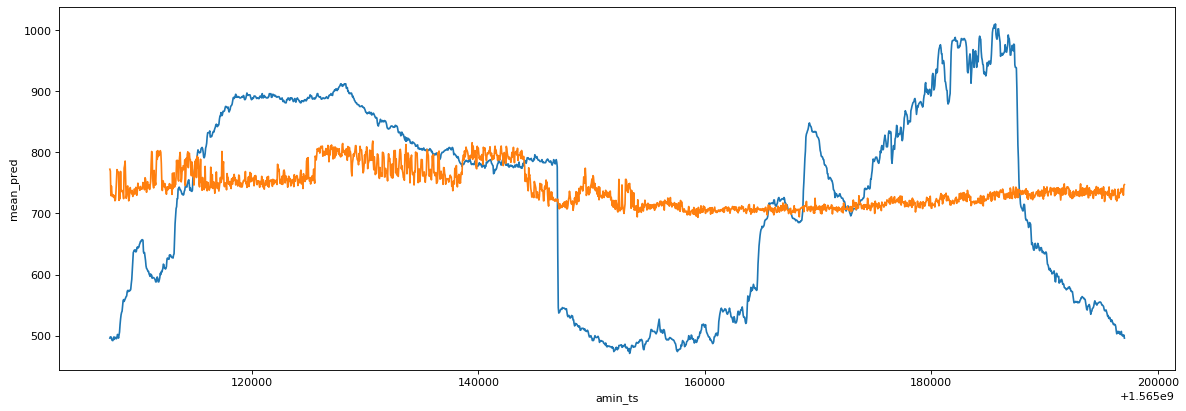

In [20]:
F1 = F
F2 = F1[['tile_jc.100', 'tile_jc.20', 'tile_jc.50', 'tile_jc.75', 'tile_jc.90', 'tile_jc.95', 'tile_jc.99', 'tile_stats.0.blur', 'tile_stats.0.blur5', 'tile_stats.0.ent', 'tile_stats.0.noise', 'tile_stats.1.blur', 'tile_stats.1.blur5', 'tile_stats.1.ent', 'tile_stats.1.noise', 'tile_stats.2.blur', 'tile_stats.2.blur5', 'tile_stats.2.ent', 'tile_stats.2.noise', 'tile_stats.3.blur', 'tile_stats.3.blur5', 'tile_stats.3.ent', 'tile_stats.3.noise', 'tile_pc']]
FP = mlp_model.predict(F2)
F1['pred'] = FP
F3 = F1[['ts','co2','pred']]
cop = pd.pivot_table(F3, index=['time'], values=['ts','co2','pred'], aggfunc=[np.max,np.min,np.mean])
cop.columns = cop.columns.to_series().str.join('_')

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
sns.lineplot(x=cop["amin_ts"], y=cop['amin_co2'])
#sns.lineplot(x=cop["amin_ts"], y=cop['amin_pred'])
#sns.lineplot(x=cop["amin_ts"], y=cop['amax_pred'])
sns.lineplot(x=cop["amin_ts"], y=cop['mean_pred'])
plt.show()